In [1]:
from rebinning import station_radii, draw_wheels, make_concentric_disks, make_disk, station3_boundaries, rebin,assign_colors, make_rebin_regions
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import mplhep as hep

from ResNet import *
from drawing_utilities import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


In [2]:
dir = ""
file = "hRHGlobalm2_280824_s1.npz" #Used to load GOOD-BAD flags
data_l = np.load(dir+file)
#data.files has "bad_flag": 1 for good data, -1 for bad data
data_np = np.array(data_l["bad_flag"])

# Filter data to only include images with a bad flag of 1 or -1
valid_data_filter = np.isin(data_l["bad_flag"], [-1, 1])

In [3]:
out_label = "060924"
me = "hRHGlobalm2"
data = dict(np.load(me+'_'+out_label+'_s1_5.npz'))
data['bad_flag']=data_l['bad_flag']

# Apply the filter to the entire dictionary
valid_data = {key: data[key][valid_data_filter] for key in data.keys()}
print(f"Removed {len(data['bad_flag']) - len(valid_data['bad_flag'])} ambigious images")

Removed 79 ambigious images


In [4]:
data_out_flags = dict(np.load("hRHGlobalm2_060924_s3_mypredictions.npz"))["my_labels"]
len(data_out_flags)
data_out_flags = data_out_flags[:len(valid_data['bad_flag'])]
len(data_out_flags)

8472

In [5]:
np.unique(data_out_flags, return_counts=True)

(array([0, 1]), array([ 818, 7654]))

In [6]:
#for i in range(len(data_out_flags)):
#    if data_out_flags[i] == 0:
#        valid_data["bad_flag"][i] = 1

In [7]:
imgs_in = np.array(valid_data["imgs_in"])
imgs_out = np.array(valid_data["imgs_out"])
valid_imgs = np.array([img_in + img_out for img_in, img_out in zip(imgs_in, imgs_out)])
valid_labels = valid_data["bad_flag"] # 1 = Good; -1 = Bad inner

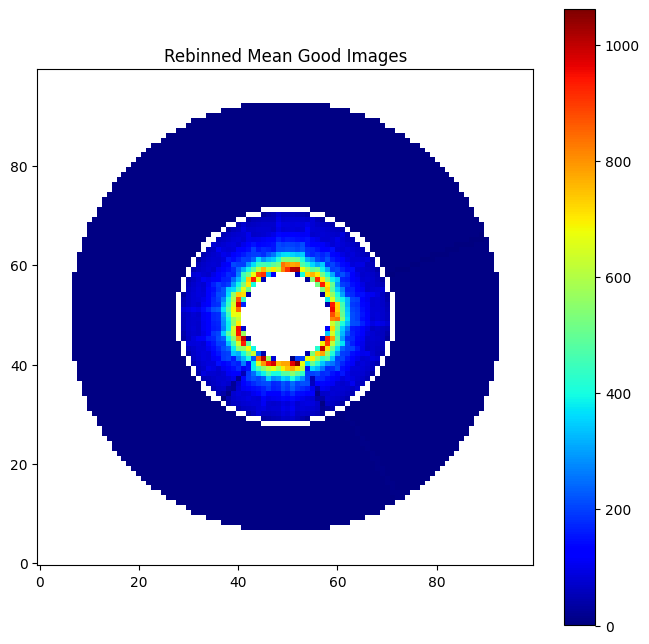

In [8]:
mean_matrix = np.mean(valid_imgs[valid_labels == 1], axis=0)
Show2Dimg(mean_matrix, title="Rebinned Mean Good Images")
mean_matrix[mean_matrix == 0] = np.nan

In [9]:
bad_data_out = dict(np.load("hRHGlobalm2_180924_outer_anomalies.npz"))

In [10]:
bad_data_out.keys()

dict_keys(['no_rebin_imgs', 'label'])

In [11]:
def zero_circle(img, in_=True):
    img_ = img.copy()
    for i in range(100):
        for j in range(100):
            if (int(math.sqrt((i-49.5)**2 + (j-49.5)**2)) == 21):
                img_[i,j]=0

            if (int(math.sqrt((i-49.5)**2 + (j-49.5)**2)) < 21) and (in_==False):
                img_[i,j]=0
            elif (int(math.sqrt((i-49.5)**2 + (j-49.5)**2)) > 21) and (in_==True):
                img_[i,j]=0         
    return img_
    
def normalize(imgs, lumis, in_=True):
    imgs_ = [zero_circle(img * (300 / lumi), in_) for img, lumi in zip(imgs, lumis)]
    return imgs_

def normalize_2(imgs, in_=True):
    imgs_ = [zero_circle(img, in_) for img in imgs]
    return imgs_

In [12]:
inner_radius, outer_radius = station3_boundaries()
regions = make_rebin_regions(np.mean(bad_data_out['no_rebin_imgs'], axis=0), inner_radius, outer_radius,5,1) #make_rebin_regions(sum_img,inner_radius,outer_radius,3,1)
for i in range(100):
    for j in range(100):
        if (int(math.sqrt((i-49.5)**2 + (j-49.5)**2)) == 21):
            regions[i,j]=0
new_imgs = np.array([rebin(regions, img) for img in bad_data_out['no_rebin_imgs']])
new_imgs_in = normalize_2(new_imgs, True)
new_imgs_out = normalize_2(new_imgs, False)


In [13]:
labels_bad = np.array(bad_data_out['label'])
#labels_bad = np.full(new_imgs.shape[0], -100)
#for l in range(len(labels_bad)):
#    if bad_data_out["label"][l]==-1:
#        labels_bad[l]=-10*bad_data_out["n_slices"][l]
#    else:
#        labels_bad[l]=-100*bad_data_out["n_slices"][l]

In [14]:
imgs_in = np.concatenate((imgs_in, new_imgs_in))
imgs_out = np.concatenate((imgs_out, new_imgs_out))
valid_labels = np.concatenate((valid_labels, labels_bad))

In [15]:
out_label = "060924"
me = "hRHGlobalm2"
# Load the saved state 
model_in = ResNetAE(1, 3, [16, 32, 64], img_size=(100,100)).to(device)
model_in.load_state_dict(torch.load(me+"_model_"+out_label+"_inner.pth"))

model_out = ResNetAE(1, 3, [16, 32, 64], img_size=(100,100)).to(device)
model_out.load_state_dict(torch.load(me+"_model_"+out_label+"_outer.pth"))

# Assign labels to the images: 0 for good, 1 for bad
valid_labels = valid_labels.astype(int)
mixed_dataset = [[label,(torch.tensor(np.nan_to_num((img_in), nan=0), dtype=torch.float32)).unsqueeze(0), (torch.tensor(np.nan_to_num((img_out), nan=0), dtype=torch.float32)).unsqueeze(0)] for label, img_in, img_out in zip(valid_labels, imgs_in, imgs_out)]

# Create a DataLoader for the mixed dataset
mixed_loader = DataLoader(dataset=mixed_dataset,
                          batch_size=32,
                          num_workers=10,
                          shuffle=False)

#### Studying distribution of losses

In [16]:
inner_radius, outer_radius = station3_boundaries()
empty_img = np.zeros((100,100), dtype=np.int16) 
inner_regions = make_rebin_regions(mean_matrix,7.,inner_radius,wheel_division=3, radial_division=1)
inner_regions = inner_regions*(mean_matrix>0)
outer_regions = make_rebin_regions(mean_matrix,inner_radius,outer_radius,wheel_division=5, radial_division=1)
outer_regions = outer_regions*(mean_matrix>0)

In [17]:
np.savez('regions.npz', regions=[assign_colors(inner_regions), assign_colors(outer_regions)])

In [18]:
outer_regions_veto = np.zeros_like(outer_regions)
outer_regions_veto = np.where(outer_regions == 3084, 1, outer_regions_veto)

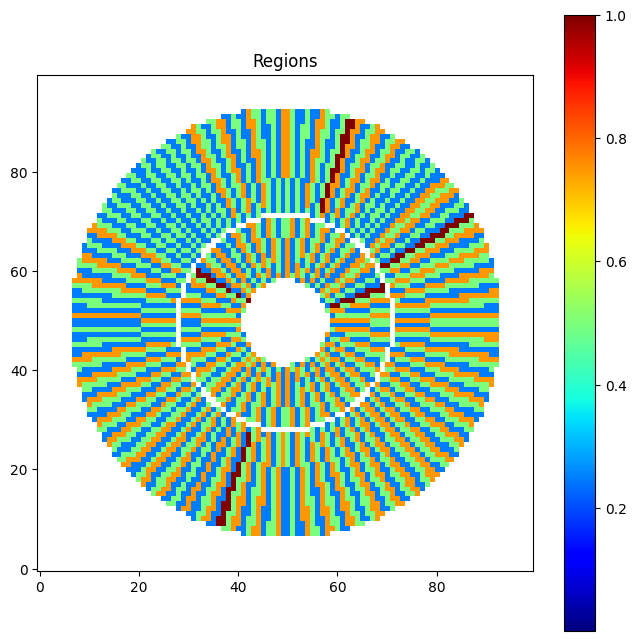

In [19]:
Show2Dimg(assign_colors(inner_regions+outer_regions), title = "Regions")
#print(np.unique(outer_regions))

In [20]:
def plot_data(
    good_df,
    bad_df,
    good_col,
    bad_col,
    percentiles_min,
    percentiles_max,
    color_good,
    color_bad,
    label_good,
    label_bad,
    threshold_type="upper", chamber ="ME-2/1"
):
    hep.style.use("CMS")
    fig, ax = plt.subplots(figsize=(14, 8))
    hep.cms.label("Preliminary", data=True, ax=ax, loc=0, com=13.6, year=2024, lumi=61.5)
    ax.ticklabel_format(style="sci", scilimits=(-3, 3), useMathText=True)
    ax.get_yaxis().get_offset_text().set_position((-0.085, 1.05))

    good_bounds = np.percentile(good_df[good_col], [percentiles_min, percentiles_max])
    bad_bounds = np.percentile(bad_df[bad_col], [percentiles_min, percentiles_max])
    x_range = [min(good_bounds[0], bad_bounds[0]), max(good_bounds[1], bad_bounds[1])]
    ax.set_xlim(x_range)

    num_bins = 80
    bins = np.linspace(x_range[0], x_range[1], num_bins)
    ax.hist(good_df[good_col], bins=num_bins, color=color_good, histtype='step', linewidth=1.5, label=label_good, range=(x_range[0], x_range[1]))
    ax.hist(bad_df[bad_col], bins=num_bins, color=color_bad, histtype='step', linewidth=1.5, label=label_bad, range=(x_range[0], x_range[1]))
    
    ax.set_yscale("log")

    if threshold_type == "upper":
        ax.set_xlabel("Maximum of Loss")
    else:
        ax.set_xlabel("Minimum of Loss")
    ax.set_ylabel("Entries")
    #ax.set_title(chamber)

    if threshold_type == "upper":
        n_good_selected = [
            len(good_df[good_df[good_col] > threshold]) for threshold in bins
        ]
        n_bad_selected = [
            len(bad_df[bad_df[bad_col] > threshold]) for threshold in bins
        ]
    else:  # 'lower'
        n_good_selected = [
            len(good_df[good_df[good_col] < threshold]) for threshold in bins
        ]
        n_bad_selected = [
            len(bad_df[bad_df[bad_col] < threshold]) for threshold in bins
        ]

    total_bad = bad_df.shape[0]
    total_good = good_df.shape[0]
    tp = np.array(n_bad_selected)
    fp = np.array(n_good_selected)
    fn = np.array([total_bad - n_bad_selected[i] for i in range(len(bins))])
    tn = np.array([total_good - n_good_selected[i] for i in range(len(bins))])

    f1 = 2 * tp / (2 * tp + fp + fn)

    threshold = bins[np.argmax(f1)]
    #ax.plot(bins, f1, color="black", label="F1 Score")
    ax.axvline(threshold, color="black", linestyle="--", label="Best Threshold")
    ax.legend()

    # Calculate precision, recall, accuracy and F1 score at the chosen threshold
    tp_at_threshold = tp[np.argmax(f1)]
    fp_at_threshold = fp[np.argmax(f1)]
    fn_at_threshold = fn[np.argmax(f1)]
    tn_at_threshold = tn[np.argmax(f1)]
    

    precision = tp_at_threshold / (tp_at_threshold + fp_at_threshold)
    accuracy = (tp_at_threshold + tn_at_threshold) / (
        tp_at_threshold + tn_at_threshold + fp_at_threshold + fn_at_threshold
    )
    tpr = tp_at_threshold / (tp_at_threshold + fn_at_threshold)
    f1_score = 2 * precision * tpr / (precision + tpr)
    fpr = fp_at_threshold / (fp_at_threshold + tn_at_threshold)
    
    # Return the metrics in a dictionary
    metrics = {
        "f1_score": f1_score,
        "accuracy": accuracy,
        "precision": precision,
        "tpr": tpr,
        "fpr": fpr,
        "best_threshold": threshold,  # Add the best threshold value
    }

    return metrics

#### Rebinning for inner-disk

In [29]:
%%time
loss_vector_in = []
loss_vector_out = []
loss_vector = []
loss_vector_no_rebin = []
imgs_vector = []
reco_imgs_vector = []
labels_vector = []

# Initialize lists to store losses for each region
inner_max_good = []
inner_min_good = []
outer_max_good = []
outer_min_good = []

inner_max_bad = []
inner_min_bad = []
outer_max_bad = []
outer_min_bad = []

for i, (labels, imgs_in, imgs_out) in enumerate(mixed_loader):    
    imgs = [in_[0]+ out_[0] for in_, out_ in zip(imgs_in.numpy(), imgs_out.numpy())]
    imgs_vector.append(imgs)
    imgs_in = imgs_in.to(device)
    imgs_out = imgs_out.to(device)
    
    reco_imgs_in = model_in(imgs_in)
    reco_imgs_out = model_out(imgs_out)
    reco_imgs = [in_[0]+ out_[0] for in_, out_ in zip(reco_imgs_in.cpu().detach().numpy(), reco_imgs_out.cpu().detach().numpy())]
    reco_imgs_vector.append(reco_imgs)
    
    losses_in = imgs_in - reco_imgs_in
    losses_out = imgs_out - reco_imgs_out

    losses_in = losses_in.view(losses_in.shape[0], -1).cpu().detach().numpy()
    losses_in /= mean_matrix.reshape(1, -1)
    losses_in = losses_in.reshape(losses_in.shape[0],100,100)
    
    losses_out = losses_out.view(losses_out.shape[0], -1).cpu().detach().numpy()
    losses_out /= mean_matrix.reshape(1, -1)
    losses_out = losses_out.reshape(losses_out.shape[0],100,100)

    losses_no_rebin = [in_+ out_ for in_, out_ in zip(losses_in, losses_out)]
    loss_vector_no_rebin.append(losses_no_rebin)

    losses_in = np.array([rebin(inner_regions,loss) for loss in losses_in])
    losses_out = np.array([np.where(outer_regions_veto == 1, 0.01, rebin(outer_regions,loss)) for loss in losses_out]) 
    
    loss_vector_in.append(losses_in)
    loss_vector_out.append(losses_out)
    losses = [in_+ out_ for in_, out_ in zip(losses_in, losses_out)]
    loss_vector.append(losses)
    
    losses_in = losses_in.reshape(losses_in.shape[0], -1)
    losses_out = losses_out.reshape(losses_out.shape[0], -1)
    
    # Calculate max and min losses for each region
    inner_max = np.nanmax(losses_in, axis=1) 
    inner_min = np.nanmin(losses_in, axis=1) 
    outer_max = np.nanmax(losses_out, axis=1) 
    outer_min = np.nanmin(losses_out, axis=1) 
    
    labels = labels.numpy()  # convert labels to numpy array for boolean indexing
    labels_vector.append(labels)
    
    # Append losses to corresponding lists
    inner_max_good.extend(inner_max[labels == 1])
    inner_min_good.extend(inner_min[labels == 1])
    outer_max_good.extend(outer_max[labels == 1])
    outer_min_good.extend(outer_min[labels == 1])
    
    inner_max_bad.extend(inner_max[labels == -1])
    inner_min_bad.extend(inner_min[labels == -1])
    outer_max_bad.extend(outer_max[(labels == -100) | (labels == -400) | (labels == -300) | (labels == -200) | (labels == -100)])
    outer_min_bad.extend(outer_min[(labels == -10) | (labels == -40) | (labels == -30) | (labels == -20) | (labels == -100)])


# Create dictionaries with all the data
good_data = {
    'inner_max_good': inner_max_good,
    'inner_min_good': inner_min_good,
    'outer_max_good': outer_max_good,
    'outer_min_good': outer_min_good,
}

bad_data = {
    'inner_max_bad': inner_max_bad,
    'inner_min_bad': inner_min_bad,
    'outer_max_bad': outer_max_bad,
    'outer_min_bad': outer_min_bad,
}

# Convert the dictionaries to DataFrames
good_df = pd.DataFrame(good_data)
bad_df_in = pd.DataFrame({k: bad_data[k] for k in ['inner_max_bad', 'inner_min_bad'] if k in bad_data})
bad_df_out_max = pd.DataFrame({k: bad_data[k] for k in ['outer_max_bad'] if k in bad_data})
bad_df_out_min = pd.DataFrame({k: bad_data[k] for k in ['outer_min_bad'] if k in bad_data})


CPU times: user 12.3 s, sys: 8.18 s, total: 20.5 s
Wall time: 21.2 s


In [30]:
bad_df_in_max = bad_df_in[bad_df_in["inner_min_bad"]>-0.5]["inner_max_bad"].to_frame()
bad_df_in_min = bad_df_in[bad_df_in["inner_max_bad"]<0.8]["inner_min_bad"].to_frame()

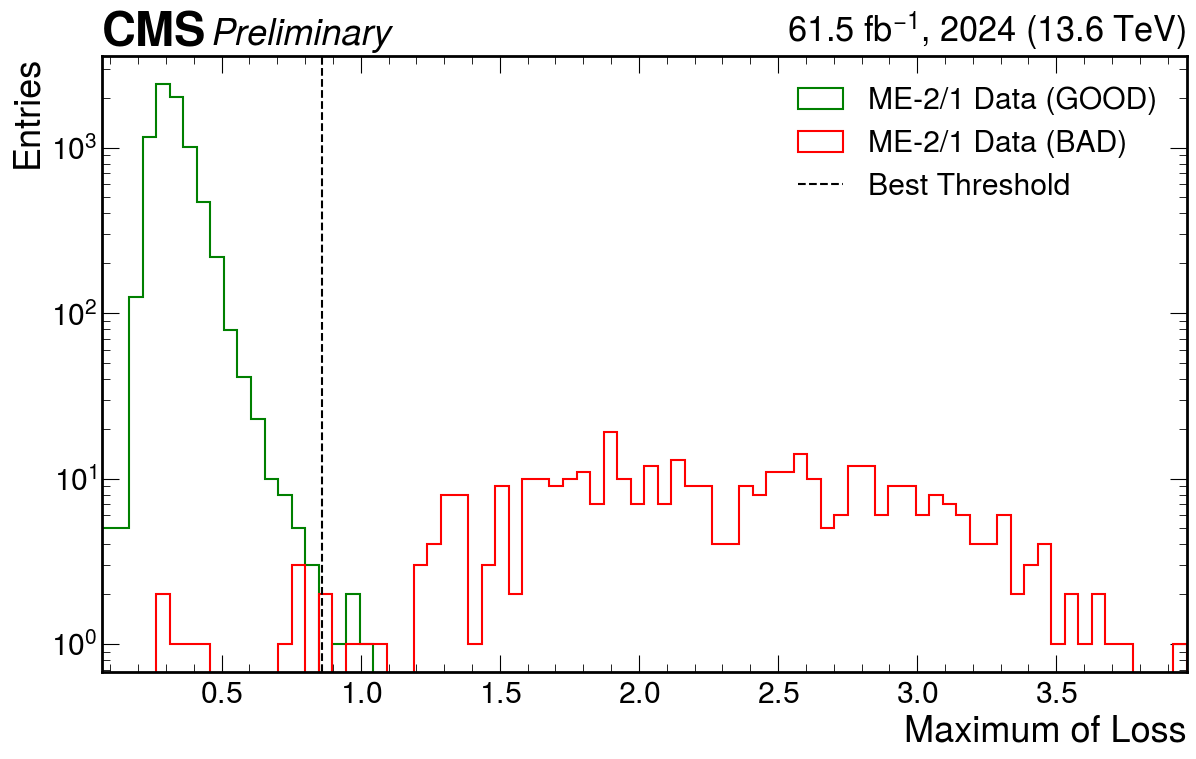

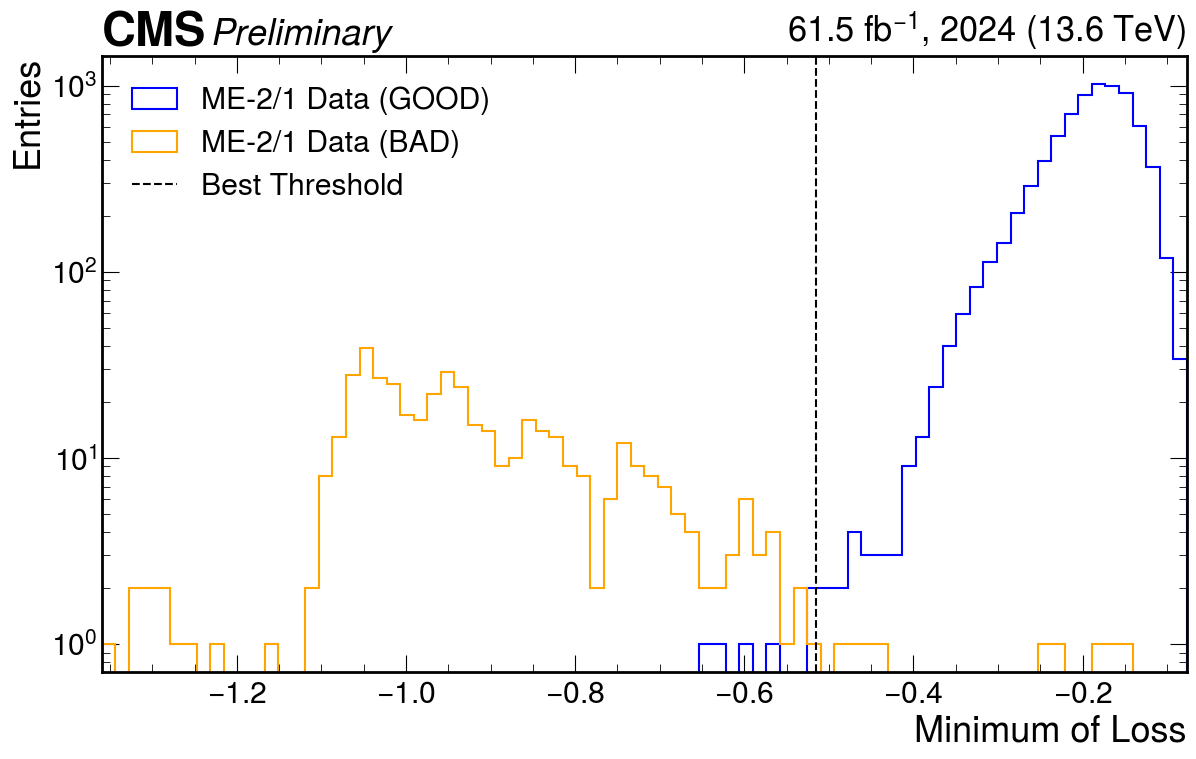

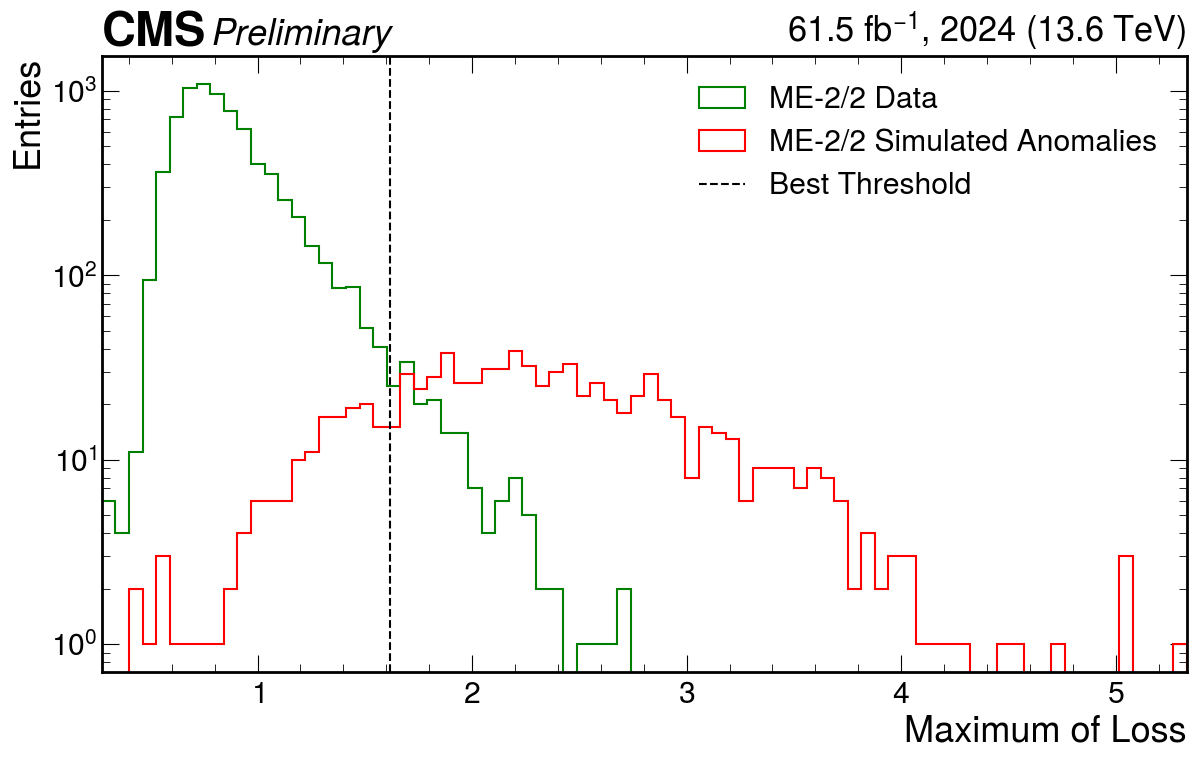

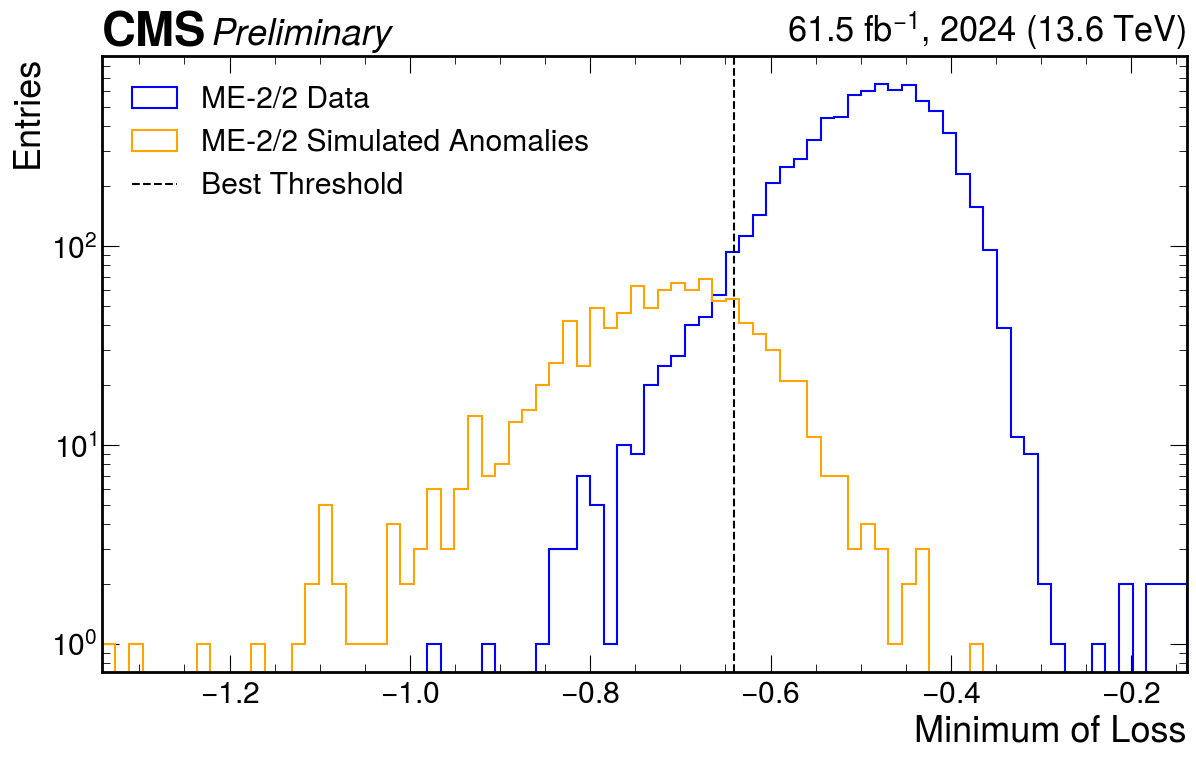

In [31]:
# Create a figure with 4 subplots

inner_percentiles_max = [0, 100]
inner_percentiles_min = [0, 100]

outer_percentiles_max = [0, 100]
outer_percentiles_min = [0, 100]


inner_max_dict = plot_data(good_df, bad_df_in_max, "inner_max_good", "inner_max_bad", inner_percentiles_max[0], inner_percentiles_max[1], "green", "red", "ME-2/1 Data (GOOD)", "ME-2/1 Data (BAD)", 'upper')
inner_min_dict = plot_data(good_df, bad_df_in_min, "inner_min_good", "inner_min_bad", inner_percentiles_min[0], inner_percentiles_min[1], "blue", "orange", "ME-2/1 Data (GOOD)", "ME-2/1 Data (BAD)", 'lower')
outer_max_dict = plot_data(good_df, bad_df_out_max, "outer_max_good", "outer_max_bad", outer_percentiles_max[0], outer_percentiles_max[1], "green", "red", "ME-2/2 Data", "ME-2/2 Simulated Anomalies", 'upper', chamber ="ME-2/2")
outer_min_dict = plot_data(good_df, bad_df_out_min, "outer_min_good", "outer_min_bad", outer_percentiles_min[0], outer_percentiles_min[1], "blue", "orange", "ME-2/2 Data", "ME-2/2 Simulated Anomalies", 'lower', chamber ="ME-2/2")

#plt.show()

In [26]:
plt.style.use('default')

In [27]:
print("inner max results:\n", inner_max_dict)
print("inner min results:\n", inner_min_dict)
print("outer max results:\n", outer_max_dict)
print("outer min results:\n", outer_min_dict)

bad_loss_low = [inner_min_dict["best_threshold"], outer_min_dict["best_threshold"]]
bad_loss_high = [inner_max_dict["best_threshold"], outer_max_dict["best_threshold"]]
print(bad_loss_low)
print(bad_loss_high)

inner max results:
 {'f1_score': 0.9829619921363041, 'accuracy': 0.9983688833124216, 'precision': 0.9894459102902374, 'tpr': 0.9765625, 'fpr': 0.0005272871078302136, 'best_threshold': 0.8594082355310645}
inner min results:
 {'f1_score': 0.9856353591160221, 'accuracy': 0.9983832856609874, 'precision': 0.9911111111111112, 'tpr': 0.9802197802197802, 'fpr': 0.0005272871078302136, 'best_threshold': -0.5151755613616751}
outer max results:
 {'f1_score': 0.867877269881027, 'accuracy': 0.9539803707742639, 'precision': 0.8608695652173913, 'tpr': 0.875, 'fpr': 0.02952807803849196, 'best_threshold': 1.524424118331716}
outer min results:
 {'f1_score': 0.8599285017874553, 'accuracy': 0.9529989094874591, 'precision': 0.8861352980576022, 'tpr': 0.8352272727272727, 'fpr': 0.022409702082784075, 'best_threshold': -0.6933240815054013}
[-0.5151755613616751, -0.6933240815054013]
[0.8594082355310645, 1.524424118331716]


In [28]:
# dictionary with all images and labels
all_data = {
    'no_rebin_imgs': valid_data['no_rebin_imgs'],
    'lumis': valid_data['lumis'],
    'entry': valid_data['entry'],
    'num': valid_data['num'],
    'run_min': valid_data['run_min'],
    'run_max': valid_data['run_max'],
    'lumi_min': valid_data['lumi_min'],
    'lumi_max': valid_data['lumi_max'],
    'loss_no_rebin':  np.concatenate(loss_vector_no_rebin),
    'imgs': np.concatenate(imgs_vector),
    'reco_imgs': np.concatenate(reco_imgs_vector),
    'loss': np.concatenate(loss_vector),
    'loss_in': np.concatenate(loss_vector_in),
    'loss_out': np.concatenate(loss_vector_out),
    'labels':  np.concatenate(labels_vector)
}
del imgs_vector
del reco_imgs_vector
del loss_vector
del loss_vector_out
del loss_vector_in
del labels_vector

43


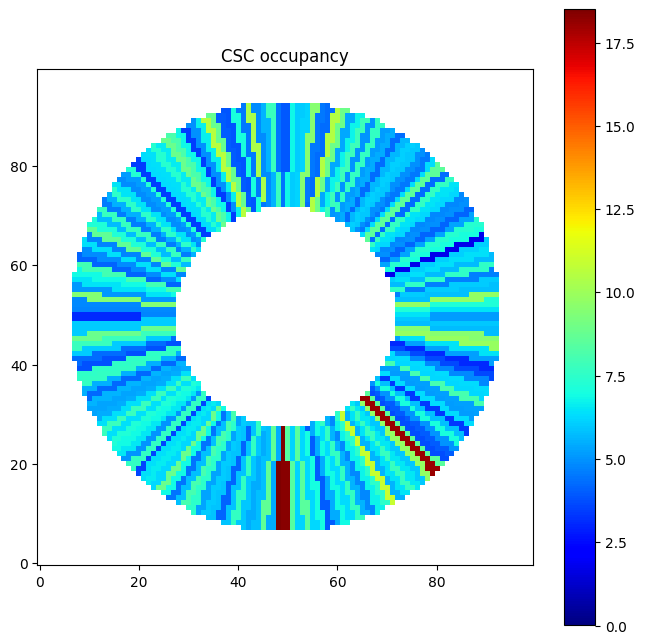

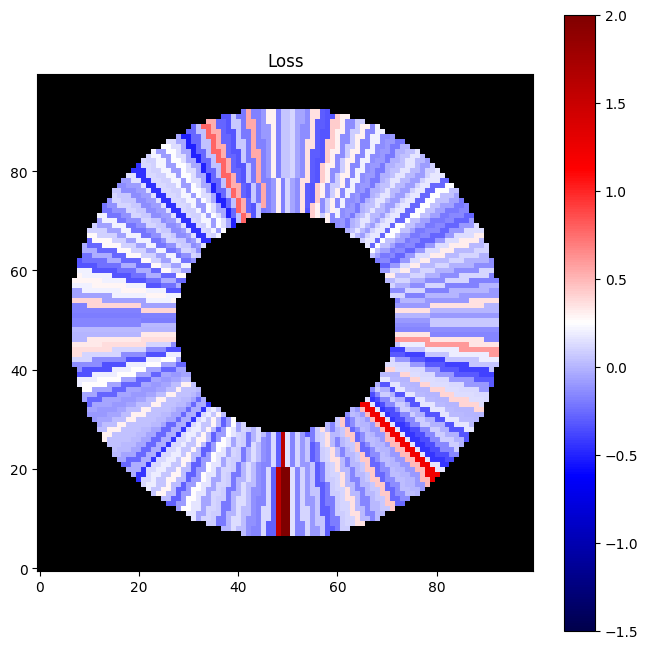

871


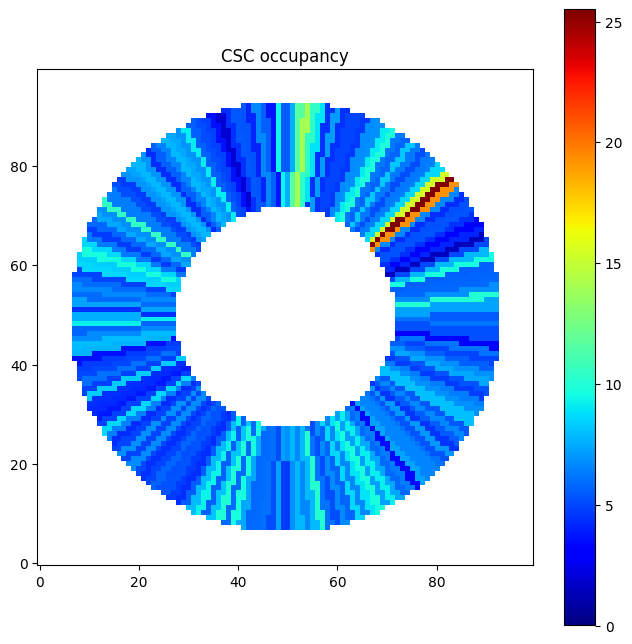

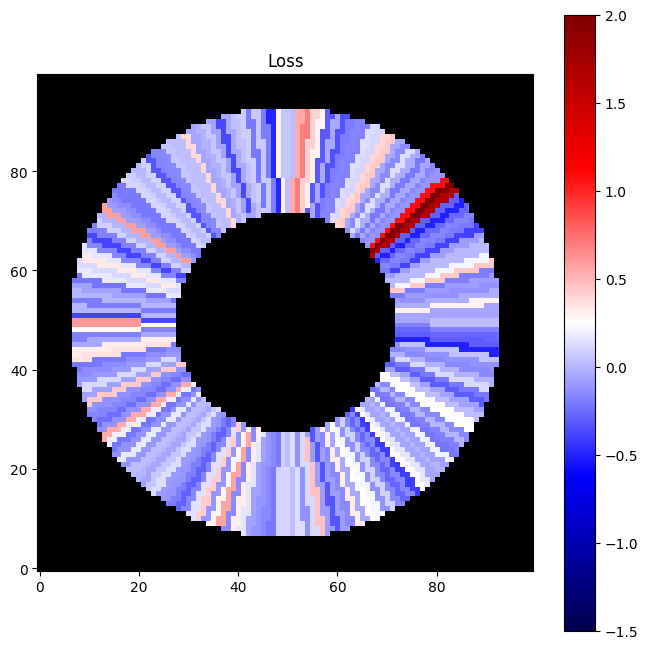

1194


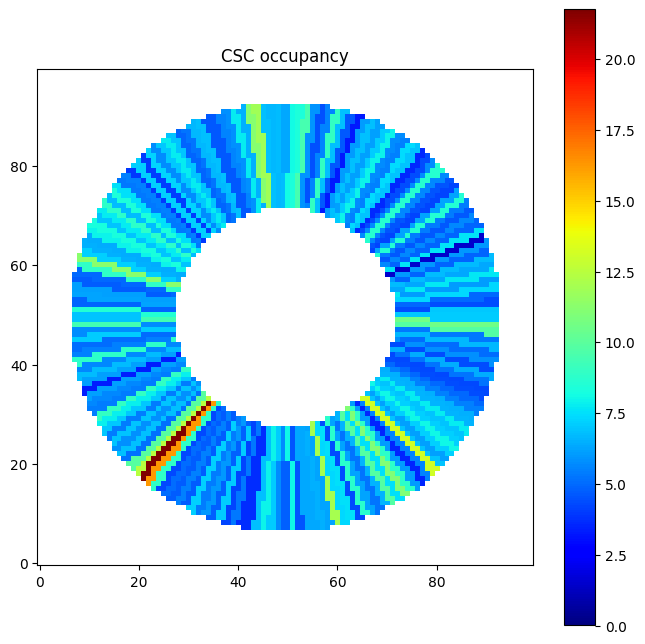

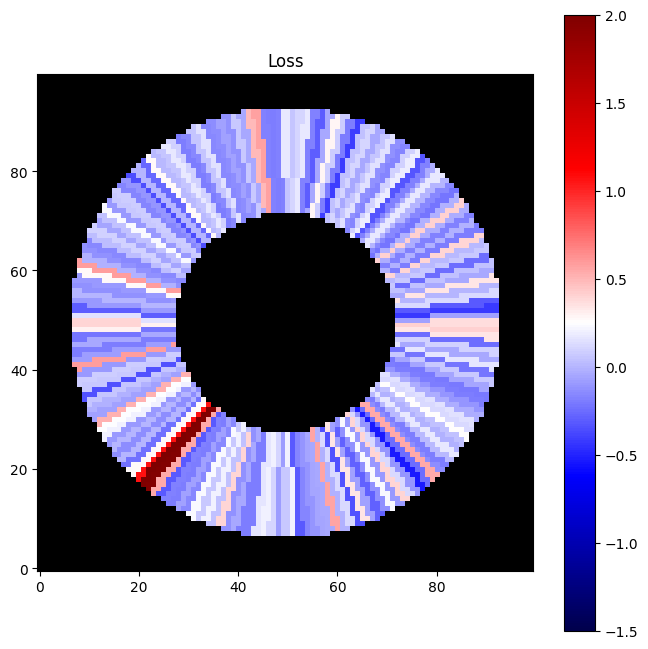

3056


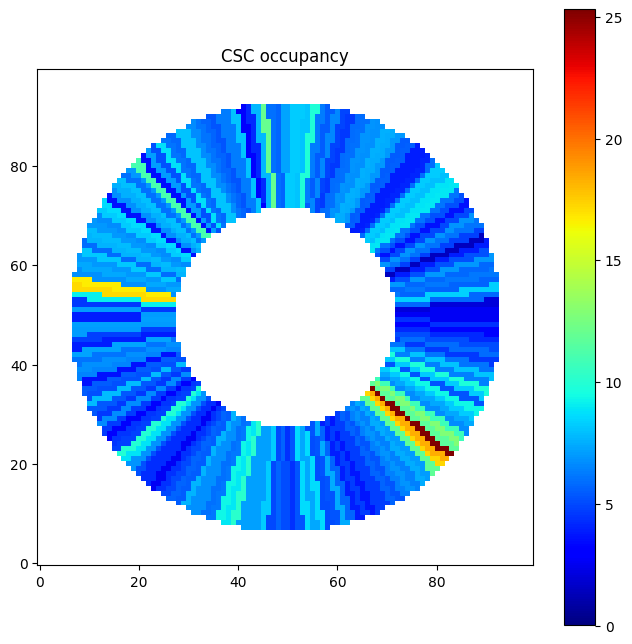

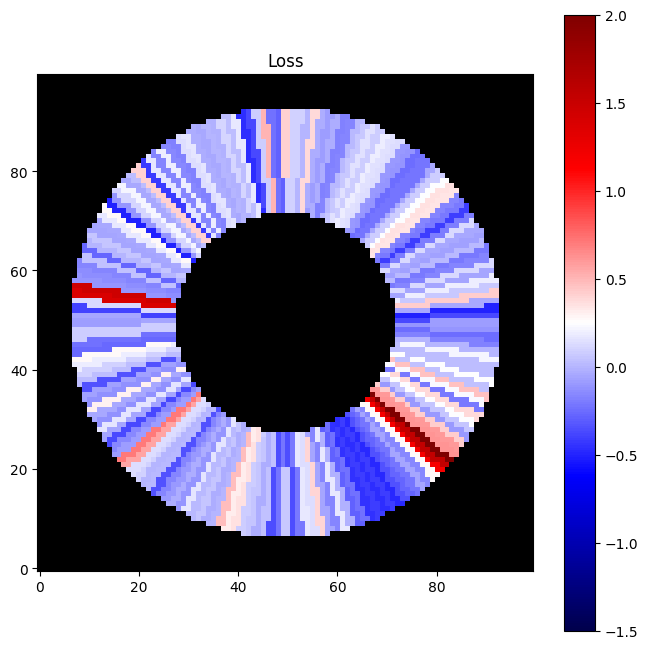

In [29]:
for i in range(len(all_data["imgs"])):
    if (np.any(all_data["loss_out"][i] > 1.7*outer_max_dict["best_threshold"])) or (np.any(all_data["loss_out"][i] < 1.7*outer_min_dict["best_threshold"])): 
        if i<8513:
            print(i)
            Show2Dimg(zero_circle(all_data["imgs"][i],False))
            Show2DLoss(all_data["loss_out"][i])
    

In [30]:
img_norebin = all_data["no_rebin_imgs"]
img_norebin_v2=[]
for i in range(len(img_norebin)):
    if (np.max(all_data["loss_out"][i])>0.2) or (np.min(all_data["loss_out"][i])<-0.3):
        print("BAD!")
    else:
        img_norebin_v2.append(img_norebin[i])

In [31]:
len(img_norebin_v2)

8472

In [32]:
all_data["predict_in"] = []
all_data["predict_out"] = []
for loss in all_data['loss_in']:
    if (np.any(loss > inner_max_dict["best_threshold"])) or (np.any(loss < inner_min_dict["best_threshold"])):
        all_data["predict_in"].append(0)
    else:
        all_data["predict_in"].append(1)

for loss in all_data['loss_out']:
    if (np.any(loss > outer_max_dict["best_threshold"])) or (np.any(loss < outer_min_dict["best_threshold"])):
        all_data["predict_out"].append(0)
    else:
        all_data["predict_out"].append(1)

all_data["predict_in"] = np.array(all_data["predict_in"])
all_data["predict_out"] = np.array(all_data["predict_out"])

In [33]:
all_data["labels_in"] = []
all_data["labels_out"] = []
for lable in all_data["labels"]:
    if lable == 1:
        all_data["labels_in"].append(1)
        all_data["labels_out"].append(1)
    if lable == -1:
        all_data["labels_in"].append(0)
        all_data["labels_out"].append(1)
    if abs(lable) != 1 and lable<-9:
        all_data["labels_in"].append(-1)
        all_data["labels_out"].append(0)
del all_data["labels"]
all_data["labels_in"] = np.array(all_data["labels_in"])
all_data["labels_out"] = np.array(all_data["labels_out"])

In [34]:
def calculate_confusion_matrix(all_data, region="in"): #in or out
    # Calculate the confusion matrix
    y_true = all_data["labels_" + region][all_data["labels_" + region] != -1] != 1
    print(len(y_true))
    y_pred = all_data["predict_" + region][all_data["labels_" + region] != -1] != 1
    # Calculate weighted confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Unpack the confusion matrix
    tn, fp, fn, tp = cm_normalized.ravel()

    return tn, fp, fn, tp

In [35]:
tn, fp, fn, tp = calculate_confusion_matrix(all_data, region="out")
print(f'True positives: {tp}')
print(f'False positives: {fp}')
print(f'True negatives: {tn}')
print(f'False negatives: {fn}')

11640
True positives: 0.8522727272727273
False positives: 0.05087346553352219
True negatives: 0.9491265344664778
False negatives: 0.14772727272727273


In [36]:
all_data.keys()

dict_keys(['no_rebin_imgs', 'lumis', 'entry', 'num', 'run_min', 'run_max', 'lumi_min', 'lumi_max', 'loss_no_rebin', 'imgs', 'reco_imgs', 'loss', 'loss_in', 'loss_out', 'predict_in', 'predict_out', 'labels_in', 'labels_out'])

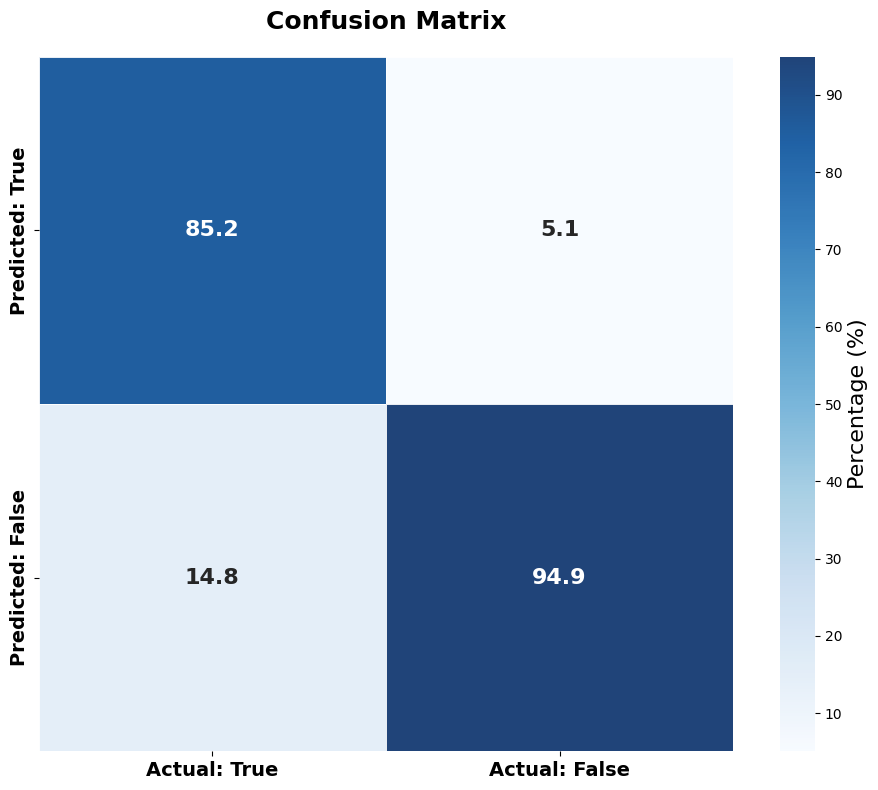

In [37]:
# Create a 2x2 confusion matrix
from matplotlib import font_manager
confusion_mat = np.array([[tp, fp], [fn, tn]])
confusion_mat = 100*confusion_mat

plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_mat, annot=True, fmt='.1f', cmap="Blues", cbar_kws={'label': 'Percentage (%)'},
                 linewidths=0.5, square=True, annot_kws={'size': 16, 'weight': 'bold'}, alpha=0.9)

# Add labels for axes
plt.title('Confusion Matrix', pad=20, fontsize=18, weight='bold')
plt.xticks([0.5, 1.5], ['Actual: True', 'Actual: False'], fontsize=14, weight='bold')
plt.yticks([0.5, 1.5], ['Predicted: True', 'Predicted: False'], fontsize=14, weight='bold')

# Access the colorbar and set font properties for its label
cbar = ax.collections[0].colorbar
cbar.set_label('Percentage (%)', fontsize=16)

# Adjust layout to prevent overlaps
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
# Calculate the True Positive Rate (TPR), also known as recall
tpr = tp / (tp + fn)
print(f'True Positive Rate (TPR): {tpr:.2f}')

# Calculate the False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f'False Positive Rate (FPR): {fpr:.2f}')

# Calculate the Precision
precision = tp / (tp + fp)
print(f'Precision: {precision:.2f}')

# Calculate the F1 score
f1 = 2 * (precision * tpr) / (precision + tpr)
print(f'F1 Score: {f1:.2f}')

# Calculate the accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy: {accuracy:.2f}')

True Positive Rate (TPR): 0.85
False Positive Rate (FPR): 0.05
Precision: 0.94
F1 Score: 0.90
Accuracy: 0.90


In [39]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
def draw_green_red_plot(all_data, id, plot=False):
    bool_matrix = (all_data["loss_in"][id] > inner_max_dict["best_threshold"]).astype(float) + (all_data["loss_in"][id] < inner_min_dict["best_threshold"]).astype(float)
    bool_matrix += (all_data["loss_out"][id] > inner_max_dict["best_threshold"]).astype(float) + (all_data["loss_out"][id] < inner_min_dict["best_threshold"]).astype(float)
    bool_matrix += (inner_regions != 0).astype(float) + (outer_regions != 0).astype(float)
    if plot==True:
        cmap = ListedColormap(['white', 'green', 'red'])
        plt.imshow(bool_matrix, cmap=cmap, vmin=0, vmax=2)
        plt.gca().invert_yaxis()
        legend_elements = [Patch(facecolor='green', edgecolor='black', label='GOOD'),
                       Patch(facecolor='red', edgecolor='black', label='BAD')]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.show()
    return bool_matrix

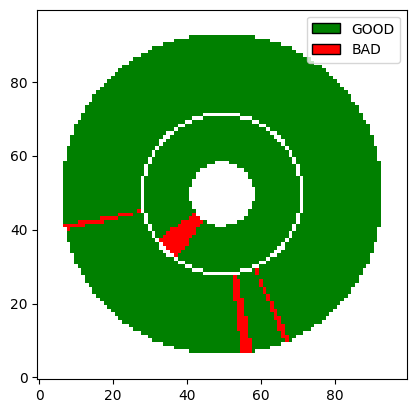

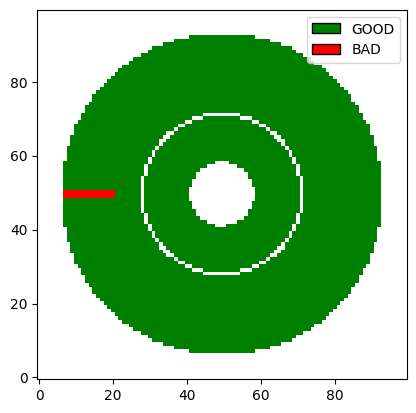

In [40]:
draw_green_red_plot(all_data, 2985, True);
draw_green_red_plot(all_data, 2984, True);

In [41]:
np.savez(me+'_'+out_label+'_s3.npz', **all_data)